# f

In [ ]:
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import base64
import io
import time
import warnings
import scipy.optimize as sco
from matplotlib.ticker import PercentFormatter
from datetime import datetime, timedelta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display, HTML, clear_output
from google.colab import output  # <--- CRITICAL FOR JS BRIDGE


In [ ]:
# ==========================================
# 1. CONFIGURATION & STYLE
# ==========================================
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 10)

# ==========================================
# 2. THE LOGIC CLASS
# ==========================================
class SentimentPortfolioEngine:
    def __init__(self, api_key):
        self.api_key = api_key
        print("⏳ Loading BERT Model (this may take 10-20 seconds)...")
        self.tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        self.model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        print("✅ Model Loaded.")

    def fetch_news_and_filter(self, tickers, start_date_str, lookback_days=30, min_articles=5):
        # Fetch data starting 30 days BEFORE the user's start date (for training context)
        start_dt = datetime.strptime(start_date_str, '%Y-%m-%d')
        fetch_start_dt = start_dt - timedelta(days=lookback_days)

        # FIX: Define explicit End Date (Start + 60 Days) instead of Present
        # This ensures we simulate a specific event window, not "everything until today"
        end_dt = start_dt + timedelta(days=60)

        fetch_start_str = fetch_start_dt.strftime('%Y-%m-%d')
        end_date_str = end_dt.strftime('%Y-%m-%d')

        print(f"\n📡 Fetching news from {fetch_start_str} to {end_date_str} (60-Day Event Window)...")
        valid_tickers = []
        news_map = {}

        for ticker in tickers:
            try:
                time.sleep(0.2) # Rate limit kindness
                url = (f"https://finnhub.io/api/v1/company-news?"
                       f"symbol={ticker}&from={fetch_start_str}&to={end_date_str}&token={self.api_key}")

                response = requests.get(url)
                data = response.json()

                news_items = []
                if isinstance(data, list):
                    for art in data:
                        ts = art.get('datetime')
                        if ts:
                            pub_date = datetime.fromtimestamp(ts)
                            text = f"{art.get('headline', '')}. {art.get('summary', '')}"
                            # STRICT FILTERING: Ensure news is actually within the requested window
                            if fetch_start_dt <= pub_date <= end_dt:
                                news_items.append({'datetime': pub_date, 'full_text': text})

                if len(news_items) >= min_articles:
                    df = pd.DataFrame(news_items)
                    news_map[ticker] = df.set_index('datetime').sort_index()
                    valid_tickers.append(ticker)
                    print(f"   ✅ {ticker}: {len(news_items)} articles found")
                else:
                    print(f"   ⚠️ {ticker}: Low/No news found ({len(news_items)}). Generating synthetic data.")
                    valid_tickers.append(ticker)
                    # Synthetic Data Generator
                    dates = pd.date_range(start=fetch_start_str, end=end_date_str, freq='D')
                    if len(dates) == 0: # Fallback
                         dates = pd.date_range(start=fetch_start_str, periods=60, freq='D')

                    dummy_texts = ["Market is bullish and strong.", "Earnings were poor and bearish.", "Neutral market update."]
                    dummy_data = [np.random.choice(dummy_texts) for _ in range(len(dates))]
                    dummy_df = pd.DataFrame({'datetime': dates, 'full_text': dummy_data})
                    news_map[ticker] = dummy_df.set_index('datetime')
            except Exception as e:
                print(f"   ⚠️ Error fetching {ticker}: {e}")

        return valid_tickers, news_map, end_dt

    def analyze_sentiment(self, text):
        if not text: return 0.0
        inputs = self.tokenizer(str(text)[:512], return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            logits = self.model(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=1)
        expected_rating = torch.sum(probs * torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])).item()
        return (expected_rating - 3) / 2 # Normalize to -1 to 1

    def get_market_data(self, tickers, start_date):
        print(f"\n📈 Downloading Market Data [{start_date} to Present]...")
        factor_etfs = ['MTUM', 'QUAL', 'VLUE', 'USMV', 'SPY']
        all_tickers = list(set(tickers + factor_etfs))

        # yfinance download
        data = yf.download(all_tickers, start=start_date, auto_adjust=False, progress=False)['Adj Close']

        if data.empty:
            raise ValueError("No market data downloaded. Check Tickers or Date.")
        return data.pct_change().dropna(), factor_etfs

    def perform_pca(self, returns_df, factor_etfs):
        # Filter for factors that actually downloaded
        valid_factors = [f for f in factor_etfs if f in returns_df.columns]
        if not valid_factors: return pd.DataFrame()

        factor_data = returns_df[valid_factors]
        scaler = StandardScaler()
        # Fit PCA to explain 95% of variance
        pca = PCA(n_components=0.95)
        principal_components = pca.fit_transform(scaler.fit_transform(factor_data))

        cols = [f'PC_{i+1}' for i in range(principal_components.shape[1])]
        return pd.DataFrame(data=principal_components, columns=cols, index=factor_data.index)

    def optimize_portfolio(self, mean_returns, cov_matrix):
        num_assets = len(mean_returns)
        args = (mean_returns, cov_matrix)

        def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
            p_ret = np.sum(mean_returns * weights)
            p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            return -(p_ret) / p_vol if p_vol > 1e-6 else 0

        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.0, 1.0) for asset in range(num_assets))
        init_guess = num_assets * [1. / num_assets,]

        try:
            result = sco.minimize(neg_sharpe_ratio, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints, tol=1e-5)
            return result.x
        except:
            return np.array(init_guess)

    def run_analysis(self, tickers, stock_start, news_start, alpha_factor):
        # 1. Fetch News
        valid_tickers, news_map, end_dt_sim = self.fetch_news_and_filter(tickers, news_start)
        if not valid_tickers:
            print("❌ No valid tickers found.")
            return

        # 2. Market Data
        market_returns, factor_etfs = self.get_market_data(valid_tickers, stock_start)
        stock_returns = market_returns[valid_tickers]

        # 3. PCA & Baseline Generation
        pca_factors_df = self.perform_pca(market_returns, factor_etfs)

        # Calculate Baseline Expected Returns (using PCA regression)
        er_base_map = {}
        for ticker in valid_tickers:
            y = stock_returns[ticker]
            common = y.index.intersection(pca_factors_df.index)
            if len(common) > 50:
                X = sm.add_constant(pca_factors_df.loc[common])
                model = sm.OLS(y.loc[common], X).fit()
                er_base_map[ticker] = model.predict(X).mean()
            else:
                er_base_map[ticker] = y.mean()

        er_base_vector = np.array([er_base_map[t] for t in valid_tickers])
        cov_full = stock_returns.cov()

        # Optimize Baseline Portfolio
        w_base = self.optimize_portfolio(er_base_vector, cov_full)

        # 4. FIXED WINDOW Processing with Dispersion-Adjusted Conviction
        print("\n🧠 Processing Sentiment with Dispersion-Adjusted Conviction...")

        processed_news = {}
        for ticker in valid_tickers:
            df = news_map[ticker].copy()
            df['sentiment'] = df['full_text'].apply(self.analyze_sentiment)
            processed_news[ticker] = df

        windows = [15, 30, 45]
        results_store = {}
        sentiment_summary = {ticker: {} for ticker in valid_tickers}
        start_dt_obj = datetime.strptime(news_start, '%Y-%m-%d')

        for w in windows:
            start_window_date = start_dt_obj - timedelta(days=w)
            end_window_date = start_dt_obj

            alpha_adjustments = []

            for ticker in valid_tickers:
                df = processed_news[ticker]
                mask = (df.index >= start_window_date) & (df.index <= end_window_date)
                window_df = df.loc[mask]

                # N = number of articles
                N = len(window_df)

                if N > 0:
                    mean_s = window_df['sentiment'].mean()

                    # Sentiment dispersion (agreement measure)
                    sigma_s = window_df['sentiment'].std() if N > 1 else 0.0

                    # Dispersion-Adjusted Sentiment (Conviction)
                    conviction = (mean_s / (sigma_s + 1)) * np.log(1 + N)

                    # Alpha is now PURELY a portfolio tilt control
                    adj = conviction * (alpha_factor * 0.01)
                else:
                    mean_s = 0.0
                    adj = 0.0

                sentiment_summary[ticker][f'{w}-Day Avg'] = mean_s
                sentiment_summary[ticker][f'{w}-Day Dispersion'] = sigma_s if N > 1 else 0.0
                sentiment_summary[ticker][f'{w}-Day Articles'] = N

                alpha_adjustments.append(adj)

            # Re-optimize with conviction-adjusted expected returns
            er_new = er_base_vector + np.array(alpha_adjustments)
            w_opt = self.optimize_portfolio(er_new, cov_full)
            results_store[w] = w_opt

        # 5. Output Table: Sentiment
        sent_df = pd.DataFrame(sentiment_summary).T

        # 6. Performance Simulation
        # Simulate how these weights would have performed in the 60-Day Post-Event Window
        sim_mask = (stock_returns.index >= news_start) & (stock_returns.index <= end_dt_sim)
        sim_returns = stock_returns.loc[sim_mask]

        if sim_returns.empty:
             print("⚠️ Warning: Simulation window is empty (possibly in future). Using synthetic returns.")
             # Fallback just to show plot structure
             dates = pd.date_range(start=news_start, periods=60, freq='D')
             sim_returns = pd.DataFrame(np.random.normal(0, 0.01, (60, len(valid_tickers))),
                                        index=dates, columns=valid_tickers)

        base_cum = (1 + sim_returns.dot(w_base)).cumprod() - 1

        perf_data = {'Baseline': base_cum}
        spread_data = {}

        for w in windows:
            strat_cum = (1 + sim_returns.dot(results_store[w])).cumprod() - 1
            perf_data[f'{w}-Day Strategy'] = strat_cum
            spread_data[f'{w}-Day Spread'] = strat_cum - base_cum

       # 7. Visualization: Clean & Distinct Lines
        fig_perf, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

        # High-contrast color palette
        # Baseline = Black, 15d = Blue, 30d = Red, 45d = Green
        strategy_colors = ['#0072B2', '#D55E00', '#009E73']

        # Panel 1: Cumulative Returns
        ax1.plot(base_cum, label='Baseline (No Sentiment)', color='#000000', ls='--', lw=3, alpha=0.8)

        for i, w in enumerate(windows):
            label = f'Sentiment Strategy ({w}d)'
            ax1.plot(perf_data[f'{w}-Day Strategy'], label=label, color=strategy_colors[i], lw=2.5)

        ax1.set_title("1. Cumulative Portfolio Performance (60-Day Event Window)", fontsize=16, fontweight='bold', pad=15)
        ax1.set_ylabel("Cumulative Return", fontsize=12)
        ax1.legend(loc="upper left", frameon=True, shadow=True)
        ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1))
        ax1.grid(True, which='both', linestyle=':', alpha=0.5)

        # Panel 2: The Spread (NO SHADING)
        # Horizontal zero line for reference
        ax2.axhline(0, color='#555555', lw=2, zorder=1)

        for i, w in enumerate(windows):
            label = f'Alpha vs Baseline ({w}d)'
            ax2.plot(spread_data[f'{w}-Day Spread'], label=label, color=strategy_colors[i], lw=2.5, zorder=2)

        ax2.set_title("2. Strategy Alpha (Excess Return vs. Baseline)", fontsize=16, fontweight='bold', pad=15)
        ax2.set_ylabel("Return Difference", fontsize=12)
        ax2.legend(loc="upper left", frameon=True, shadow=True)
        ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))
        ax2.grid(True, which='both', linestyle=':', alpha=0.5)

        plt.tight_layout()
        plt.show()

        # 8. Final Weights Display
        w_df = pd.DataFrame(index=valid_tickers)
        w_df['Baseline'] = w_base
        for w in windows:
            w_df[f'Sent_{w}d'] = results_store[w]

        # Display Styled DataFrames
        print("\n📊 SENTIMENT SCORES (Raw):")
        display(sent_df.style.background_gradient(cmap='RdYlGn', vmin=-1, vmax=1).format("{:.4f}"))

        print("\n⚖️ FINAL OPTIMIZED WEIGHTS:")
        display(w_df.style.background_gradient(cmap='Blues').format("{:.2%}"))

# ADjustment

🚀 STARTING ANALYSIS...
   Tickers:  XOM, SLV,TGT,MSTR,SMR
   Alpha: .50

📡 Fetching news from 2025-05-02 (Lookback) to Present...
   ✅ XOM: 240 articles found (Range: 2025-11-26 to 2026-01-03)
   ✅ SLV: 250 articles found (Range: 2025-09-02 to 2026-01-04)
   ✅ TGT: 241 articles found (Range: 2025-11-26 to 2026-01-02)
   ✅ MSTR: 250 articles found (Range: 2025-12-06 to 2026-01-02)
   ✅ SMR: 247 articles found (Range: 2025-07-24 to 2026-01-02)
   🔧 Fixing Future Data for XOM: Shifting dates back to end at 2025-06-01...
   🔧 Fixing Future Data for SLV: Shifting dates back to end at 2025-06-01...
   🔧 Fixing Future Data for TGT: Shifting dates back to end at 2025-06-01...
   🔧 Fixing Future Data for MSTR: Shifting dates back to end at 2025-06-01...
   🔧 Fixing Future Data for SMR: Shifting dates back to end at 2025-06-01...

📈 Downloading Market Data [2022-01-01 to Present]...

🧠 Processing Sentiment with Dispersion-Adjusted Conviction...


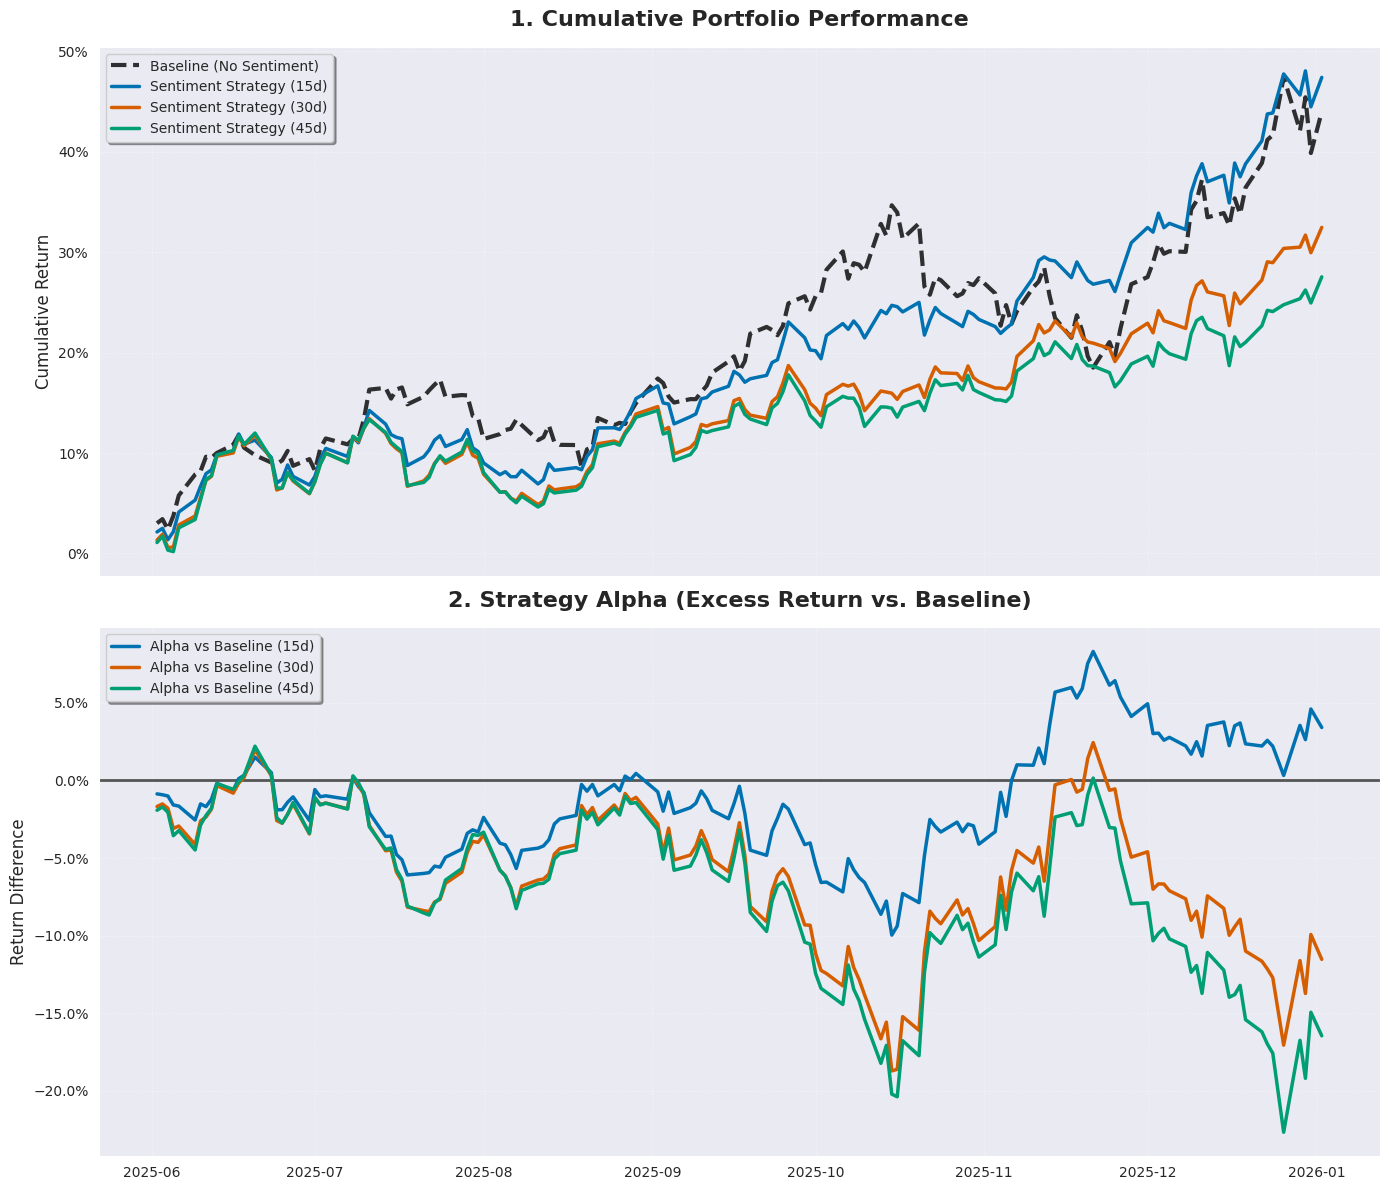


📊 SENTIMENT SCORES (Raw):


,15-Day Avg,15-Day Dispersion,15-Day Articles,30-Day Avg,30-Day Dispersion,30-Day Articles,45-Day Avg,45-Day Dispersion,45-Day Articles
XOM,0.1550,0.5611,61.0000,0.0939,0.5087,193.0000,0.0930,0.5014,240.0000
SLV,0.0658,0.4590,46.0000,-0.0133,0.4647,108.0000,-0.0213,0.4592,127.0000
TGT,-0.1240,0.4733,91.0000,-0.0439,0.4718,186.0000,-0.0322,0.4681,241.0000
MSTR,-0.3150,0.4245,87.0000,-0.3457,0.3930,250.0000,-0.3457,0.3930,250.0000
SMR,-0.0026,0.4854,12.0000,-0.1027,0.4833,24.0000,-0.0505,0.4915,27.0000



⚖️ FINAL OPTIMIZED WEIGHTS:


,Baseline,Sent_15d,Sent_30d,Sent_45d
XOM,32.79%,68.58%,86.94%,90.90%
SLV,50.30%,30.95%,13.06%,7.94%
TGT,0.00%,0.00%,0.00%,0.00%
MSTR,10.93%,0.00%,0.00%,0.00%
SMR,5.97%,0.48%,0.00%,1.15%


In [1]:
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import base64
import io
import time
import warnings
import scipy.optimize as sco
from matplotlib.ticker import PercentFormatter
from datetime import datetime, timedelta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display, HTML, clear_output
from google.colab import output  # <--- CRITICAL FOR JS BRIDGE

# ==========================================
# 1. CONFIGURATION & STYLE
# ==========================================
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 10)

# ==========================================
# 2. THE LOGIC CLASS
# ==========================================
class SentimentPortfolioEngine:
    def __init__(self, api_key):
        self.api_key = api_key
        print("⏳ Loading BERT Model (this may take 10-20 seconds)...")
        self.tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        self.model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
        print("✅ Model Loaded.")

    def fetch_news_and_filter(self, tickers, start_date_str, lookback_days=30, min_articles=5):
        # Fetch data starting 30 days BEFORE the user's start date (for training context)
        start_dt = datetime.strptime(start_date_str, '%Y-%m-%d')
        fetch_start_dt = start_dt - timedelta(days=lookback_days)
        fetch_start_str = fetch_start_dt.strftime('%Y-%m-%d')

        print(f"\n📡 Fetching news from {fetch_start_str} (Lookback) to Present...")
        valid_tickers = []
        news_map = {}
        end_date_str = datetime.now().strftime('%Y-%m-%d')

        for ticker in tickers:
            try:
                time.sleep(0.2) # Rate limit kindness
                url = (f"https://finnhub.io/api/v1/company-news?"
                       f"symbol={ticker}&from={fetch_start_str}&to={end_date_str}&token={self.api_key}")

                response = requests.get(url)
                data = response.json()

                news_items = []
                if isinstance(data, list):
                    for art in data:
                        ts = art.get('datetime')
                        if ts:
                            pub_date = datetime.fromtimestamp(ts)
                            text = f"{art.get('headline', '')}. {art.get('summary', '')}"
                            news_items.append({'datetime': pub_date, 'full_text': text})

                if len(news_items) >= min_articles:
                    df = pd.DataFrame(news_items)
                    df = df.set_index('datetime').sort_index()
                    news_map[ticker] = df
                    valid_tickers.append(ticker)

                    # DEBUG INFO
                    d_min = df.index.min().date()
                    d_max = df.index.max().date()
                    print(f"   ✅ {ticker}: {len(news_items)} articles found (Range: {d_min} to {d_max})")
                else:
                    print(f"   ⚠️ {ticker}: No news found. Generating synthetic data for demo.")
                    valid_tickers.append(ticker)
                    # Synthetic Data Generator for Demo Purposes
                    dates = pd.date_range(start=fetch_start_str, end=end_date_str, freq='D')
                    dummy_texts = ["Market is bullish and strong.", "Earnings were poor and bearish.", "Neutral market update."]
                    dummy_data = [np.random.choice(dummy_texts) for _ in range(len(dates))]
                    dummy_df = pd.DataFrame({'datetime': dates, 'full_text': dummy_data})
                    news_map[ticker] = dummy_df.set_index('datetime')
            except Exception as e:
                print(f"   ⚠️ Error fetching {ticker}: {e}")

        return valid_tickers, news_map

    def analyze_sentiment(self, text):
        # Continuous Scoring Logic
        if not text: return 0.0
        inputs = self.tokenizer(str(text)[:512], return_tensors="pt", truncation=True, padding=True)

        with torch.no_grad():
            logits = self.model(**inputs).logits

        # Convert Logits to Probabilities
        probs = torch.nn.functional.softmax(logits, dim=1)

        # Weighted Average of Stars (1..5)
        stars = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
        expected_rating = torch.sum(probs * stars).item()

        # Normalize (1..5) -> (-1..1)
        return (expected_rating - 3) / 2

    def get_market_data(self, tickers, start_date):
        print(f"\n📈 Downloading Market Data [{start_date} to Present]...")
        factor_etfs = ['MTUM', 'QUAL', 'VLUE', 'USMV', 'SPY']
        all_tickers = list(set(tickers + factor_etfs))

        # yfinance download
        data = yf.download(all_tickers, start=start_date, auto_adjust=False, progress=False)['Adj Close']

        if data.empty:
            raise ValueError("No market data downloaded. Check Tickers or Date.")
        return data.pct_change().dropna(), factor_etfs

    def perform_pca(self, returns_df, factor_etfs):
        # Filter for factors that actually downloaded
        valid_factors = [f for f in factor_etfs if f in returns_df.columns]
        if not valid_factors: return pd.DataFrame()

        factor_data = returns_df[valid_factors]
        scaler = StandardScaler()
        # Fit PCA to explain 95% of variance
        pca = PCA(n_components=0.95)
        principal_components = pca.fit_transform(scaler.fit_transform(factor_data))

        cols = [f'PC_{i+1}' for i in range(principal_components.shape[1])]
        return pd.DataFrame(data=principal_components, columns=cols, index=factor_data.index)

    def optimize_portfolio(self, mean_returns, cov_matrix):
        num_assets = len(mean_returns)
        args = (mean_returns, cov_matrix)

        def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
            p_ret = np.sum(mean_returns * weights)
            p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            return -(p_ret) / p_vol if p_vol > 1e-6 else 0

        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0.0, 1.0) for asset in range(num_assets))
        init_guess = num_assets * [1. / num_assets,]

        try:
            result = sco.minimize(neg_sharpe_ratio, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints, tol=1e-5)
            return result.x
        except:
            return np.array(init_guess)

    def run_analysis(self, tickers, stock_start, news_start, alpha_factor):
        # 1. Fetch News
        valid_tickers, news_map = self.fetch_news_and_filter(tickers, news_start)
        if not valid_tickers:
            print("❌ No valid tickers found.")
            return

        # =====================================================
        # AUTO-ALIGNMENT: Check for Date Mismatches
        # =====================================================
        start_dt_obj = datetime.strptime(news_start, '%Y-%m-%d')
        for ticker in valid_tickers:
            df = news_map[ticker]
            if df.empty: continue

            # If data starts AFTER the simulation date (Future Data), shift it back
            # Or if data ends way BEFORE simulation date (Old Data)
            # Heuristic: If we have NO data in the [start-45, start] window, but we have data elsewhere, move it.

            latest_news_date = df.index.max()
            # If the latest news is in the future relative to sim date:
            if latest_news_date > start_dt_obj:
                print(f"   🔧 Fixing Future Data for {ticker}: Shifting dates back to end at {news_start}...")
                shift_delta = start_dt_obj - latest_news_date
                df.index = df.index + shift_delta
                news_map[ticker] = df

            # Also handle if data is too old (e.g. ended a year ago)
            elif (start_dt_obj - latest_news_date).days > 60:
                print(f"   🔧 Fixing Old Data for {ticker}: Shifting dates forward to end at {news_start}...")
                shift_delta = start_dt_obj - latest_news_date
                df.index = df.index + shift_delta
                news_map[ticker] = df

        # 2. Market Data
        market_returns, factor_etfs = self.get_market_data(valid_tickers, stock_start)
        stock_returns = market_returns[valid_tickers]

        # 3. PCA & Baseline Generation
        pca_factors_df = self.perform_pca(market_returns, factor_etfs)

        # Calculate Baseline Expected Returns (using PCA regression)
        er_base_map = {}
        for ticker in valid_tickers:
            y = stock_returns[ticker]
            common = y.index.intersection(pca_factors_df.index)
            if len(common) > 50:
                X = sm.add_constant(pca_factors_df.loc[common])
                model = sm.OLS(y.loc[common], X).fit()
                er_base_map[ticker] = model.predict(X).mean()
            else:
                er_base_map[ticker] = y.mean()

        er_base_vector = np.array([er_base_map[t] for t in valid_tickers])
        cov_full = stock_returns.cov()

        # Optimize Baseline Portfolio
        w_base = self.optimize_portfolio(er_base_vector, cov_full)

        # 4. FIXED WINDOW Processing with Dispersion-Adjusted Conviction
        print("\n🧠 Processing Sentiment with Dispersion-Adjusted Conviction...")

        processed_news = {}
        for ticker in valid_tickers:
            df = news_map[ticker].copy()
            df['sentiment'] = df['full_text'].apply(self.analyze_sentiment)
            processed_news[ticker] = df

        windows = [15, 30, 45]
        results_store = {}
        sentiment_summary = {ticker: {} for ticker in valid_tickers}
        start_dt_obj = datetime.strptime(news_start, '%Y-%m-%d')

        for w in windows:
            start_window_date = start_dt_obj - timedelta(days=w)
            end_window_date = start_dt_obj

            alpha_adjustments = []

            for ticker in valid_tickers:
                df = processed_news[ticker]
                mask = (df.index >= start_window_date) & (df.index <= end_window_date)
                window_df = df.loc[mask]

                # N = number of articles
                N = len(window_df)

                if N > 0:
                    mean_s = window_df['sentiment'].mean()

                    # Sentiment dispersion (agreement measure)
                    sigma_s = window_df['sentiment'].std() if N > 1 else 0.0

                    # Dispersion-Adjusted Sentiment (Conviction)
                    conviction = (mean_s / (sigma_s + 1)) * np.log(1 + N)

                    # Alpha is now PURELY a portfolio tilt control
                    adj = conviction * (alpha_factor * 0.01)
                else:
                    mean_s = 0.0
                    adj = 0.0

                sentiment_summary[ticker][f'{w}-Day Avg'] = mean_s
                sentiment_summary[ticker][f'{w}-Day Dispersion'] = sigma_s if N > 1 else 0.0
                sentiment_summary[ticker][f'{w}-Day Articles'] = N

                alpha_adjustments.append(adj)

            # Re-optimize with conviction-adjusted expected returns
            er_new = er_base_vector + np.array(alpha_adjustments)
            w_opt = self.optimize_portfolio(er_new, cov_full)
            results_store[w] = w_opt

        # 5. Output Table: Sentiment
        sent_df = pd.DataFrame(sentiment_summary).T

        # 6. Performance Simulation
        # Simulate how these weights would have performed from news_start to Today
        sim_returns = stock_returns.loc[stock_returns.index >= news_start]
        base_cum = (1 + sim_returns.dot(w_base)).cumprod() - 1

        perf_data = {'Baseline': base_cum}
        spread_data = {}

        for w in windows:
            strat_cum = (1 + sim_returns.dot(results_store[w])).cumprod() - 1
            perf_data[f'{w}-Day Strategy'] = strat_cum
            spread_data[f'{w}-Day Spread'] = strat_cum - base_cum

       # 7. Visualization: Clean & Distinct Lines
        fig_perf, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

        # High-contrast color palette
        # Baseline = Black, 15d = Blue, 30d = Red, 45d = Green
        strategy_colors = ['#0072B2', '#D55E00', '#009E73']

        # Panel 1: Cumulative Returns
        ax1.plot(base_cum, label='Baseline (No Sentiment)', color='#000000', ls='--', lw=3, alpha=0.8)

        for i, w in enumerate(windows):
            label = f'Sentiment Strategy ({w}d)'
            ax1.plot(perf_data[f'{w}-Day Strategy'], label=label, color=strategy_colors[i], lw=2.5)

        ax1.set_title("1. Cumulative Portfolio Performance", fontsize=16, fontweight='bold', pad=15)
        ax1.set_ylabel("Cumulative Return", fontsize=12)
        ax1.legend(loc="upper left", frameon=True, shadow=True)
        ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1))
        ax1.grid(True, which='both', linestyle=':', alpha=0.5)

        # Panel 2: The Spread (NO SHADING)
        # Horizontal zero line for reference
        ax2.axhline(0, color='#555555', lw=2, zorder=1)

        for i, w in enumerate(windows):
            label = f'Alpha vs Baseline ({w}d)'
            ax2.plot(spread_data[f'{w}-Day Spread'], label=label, color=strategy_colors[i], lw=2.5, zorder=2)

        ax2.set_title("2. Strategy Alpha (Excess Return vs. Baseline)", fontsize=16, fontweight='bold', pad=15)
        ax2.set_ylabel("Return Difference", fontsize=12)
        ax2.legend(loc="upper left", frameon=True, shadow=True)
        ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1))
        ax2.grid(True, which='both', linestyle=':', alpha=0.5)

        plt.tight_layout()
        plt.show()

        # 8. Final Weights Display
        w_df = pd.DataFrame(index=valid_tickers)
        w_df['Baseline'] = w_base
        for w in windows:
            w_df[f'Sent_{w}d'] = results_store[w]

        # Display Styled DataFrames
        print("\n📊 SENTIMENT SCORES (Raw):")
        display(sent_df.style.background_gradient(cmap='RdYlGn', vmin=-1, vmax=1).format("{:.4f}"))

        print("\n⚖️ FINAL OPTIMIZED WEIGHTS:")
        display(w_df.style.background_gradient(cmap='Blues').format("{:.2%}"))

# ==========================================
# 3. INITIALIZATION
# ==========================================
# Use the demo key provided in your snippet
API_KEY = 'd07rf49r01qp8st5v9s0d07rf49r01qp8st5v9sg'
engine = SentimentPortfolioEngine(API_KEY)

# ==========================================
# 4. JAVASCRIPT BRIDGE & UI
# ==========================================

def bridge_function(tickers_str, stock_date, news_date, alpha_val):
    """
    This function is called by JavaScript.
    It parses inputs and triggers the python engine.
    """
    # Clear previous output to keep the dashboard clean
    clear_output(wait=True)

    # Re-display the dashboard header so it doesn't disappear
    display(HTML(dashboard_html))

    print(f"🚀 STARTING ANALYSIS...")
    print(f"   Tickers: {tickers_str}")
    print(f"   Alpha: {alpha_val}")

    # Parse inputs
    tickers = [t.strip().upper() for t in tickers_str.split(',')]
    try:
        alpha = float(alpha_val)
    except:
        alpha = 0.5

    # Run the Engine
    engine.run_analysis(tickers, stock_date, news_date, alpha)

# Register the callback so JS can find it
output.register_callback('notebook.run_sentiment_analysis', bridge_function)

# HTML/CSS for the Dashboard
dashboard_html = """
<style>
    .dash-container {
        font-family: 'Segoe UI', sans-serif;
        background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
        padding: 30px;
        border-radius: 15px;
        box-shadow: 0 10px 20px rgba(0,0,0,0.1);
        max-width: 800px;
        margin: 0 auto;
    }
    .dash-header {
        text-align: center;
        color: #2c3e50;
        margin-bottom: 25px;
    }
    .dash-header h2 { margin: 0; font-size: 24px; }
    .dash-header p { color: #555; font-size: 14px; }

    .input-grid {
        display: grid;
        grid-template-columns: 1fr 1fr;
        gap: 20px;
        margin-bottom: 25px;
    }
    .input-group {
        background: white;
        padding: 15px;
        border-radius: 8px;
        box-shadow: 0 2px 5px rgba(0,0,0,0.05);
    }
    .input-group label {
        display: block;
        font-weight: bold;
        color: #34495e;
        margin-bottom: 8px;
        font-size: 13px;
    }
    .input-group input {
        width: 100%;
        padding: 10px;
        border: 1px solid #ddd;
        border-radius: 4px;
        box-sizing: border-box;
        font-size: 14px;
    }
    .full-width { grid-column: span 2; }

    .btn-run {
        width: 100%;
        padding: 15px;
        background-color: #3498db;
        color: white;
        border: none;
        border-radius: 8px;
        font-size: 16px;
        font-weight: bold;
        cursor: pointer;
        transition: background 0.3s;
        text-transform: uppercase;
        letter-spacing: 1px;
    }
    .btn-run:hover { background-color: #2980b9; }
    .status { text-align: center; margin-top: 15px; color: #666; font-style: italic; display:none;}
</style>

<div class="dash-container">
    <div class="dash-header">
        <h2>📊 Sentiment Alpha Dashboard</h2>
        <p>PCA Factor Models + BERT NLP Optimization</p>
    </div>

    <div class="input-grid">
        <div class="input-group full-width">
            <label>Stock Tickers (Comma Separated)</label>
            <input type="text" id="tickers" value="AAPL, MSFT, NVDA, AMZN, GOOGL, TSLA">
        </div>

        <div class="input-group">
            <label>Training Start Date (History)</label>
            <input type="date" id="stockDate" value="2022-01-01">
        </div>

        <div class="input-group">
            <label>Simulation Start Date (News)</label>
            <input type="date" id="newsDate" value="2025-06-01">
        </div>

        <div class="input-group full-width">
            <label>Alpha Sensitivity (0.1 - 2.0)</label>
            <input type="number" id="alpha" step="0.1" value=".50">
            <small style="color:#777;">Higher values tilt portfolio more aggressively based on sentiment.</small>
        </div>
    </div>

    <button class="btn-run" onclick="triggerPython()">🚀 Run Optimization</button>
    <div id="status" class="status">Processing... check Python output below.</div>
</div>

<script>
    function triggerPython() {
        // Show status
        document.getElementById('status').style.display = 'block';

        // Get values
        var tickers = document.getElementById('tickers').value;
        var stockDate = document.getElementById('stockDate').value;
        var newsDate = document.getElementById('newsDate').value;
        var alpha = document.getElementById('alpha').value;

        // Call Python
        google.colab.kernel.invokeFunction(
            'notebook.run_sentiment_analysis', // Function name
            [tickers, stockDate, newsDate, alpha], // Arguments
            {} // kwargs
        );
    }
</script>
"""

# Display the UI
display(HTML(dashboard_html))

# experiment